### Obeter question do dataset

In [1]:
import manager_dataset as MD


questions = MD.questions(treated=True)
print(len(questions))

4376


### Configurar classificadores de pergunta

In [2]:
import question_processing as QP


incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed
print(len(questions))
train_questions, test_questions = MD.split_questions(questions)
print('Train:', len(train_questions), 'Test:',len(test_questions))

2349
Train: 1705 Test: 644


In [3]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER, max_features=1000)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        ret = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        return ret

class HybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            bow = self.bow.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, bow[0]]))
        ret = np.array(ret)
        return ret

class TfidfHybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.tf = tfidf_vectorizer()
        
    
    def fit(self, X, y):
        self.tf.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            tf = self.tf.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, tf[0]]))
        ret = np.array(ret)
        return ret

class SequenceHybridVectorizer(object):
    def __init__(self, word2vec, tfidf=False):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.word2weight = None
        self.tfidf = tfidf
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            vector = np.array([])
            maxWords = 32
            count = 0
            for word in sentence:
                if count < maxWords:
                    if word in self.word2vec:
                        count += 1
                        if self.tfidf:
                            vector = np.concatenate([vector, self.word2vec[word] * self.word2weight[word]])
                        else:
                            vector = np.concatenate([vector, self.word2vec[word]])
            for i in range(maxWords-count):
                vector = np.concatenate([vector, np.zeros(self.dim)])
            bow = self.bow.transform([sentence]).toarray()
            vector = np.concatenate([vector, bow[0]])
            ret.append(vector)
        
        ret = np.array(ret)
        return ret

#### Carregar modelo W2V

In [4]:
%%time
from gensim.models import KeyedVectors

w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

C:\Users\55519\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\55519\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Wall time: 3min 34s


#### Definir classificadores

In [16]:
from sklearn.svm import LinearSVC


labels = ["BOW", 
          "TFIDF", 
          "W2V",
          "HYBRID"]

labels = ["BOW", "HYBRID"]

classifiers = {}  # {'classifier': (VectorizeModel, Classifier)}


#classifiers[labels[0]] = (LinearSVC(), count_vectorizer())
#classifiers[labels[1]] = (LinearSVC(), tfidf_vectorizer())
#classifiers[labels[2]] = (LinearSVC(), MeanEmbeddingVectorizer(model_w2v))
#classifiers[labels[3]] = (LinearSVC(), QP.HybridVectorizer(model_w2v))
#classifiers[labels[3]] = (LinearSVC(), TfidfHybridVectorizer(model_w2v))


classifiers[labels[0]] = (LinearSVC(), count_vectorizer())
classifiers[labels[1]] = (LinearSVC(), HybridVectorizer(model_w2v))

### Carregar modelo de NER

In [7]:
import named_entity_recognition as NER
import dill
ner_model = dill.load(open(NER.file_ner, 'rb'))

### Carregar modelo de IR

In [8]:
%%time
import information_retrieval as IR
ir = IR.InformationRetrieval()
ir.start(reset=False)
QP.queryFormulation(test_questions)
ir.retrievalDocuments(test_questions)
IR.retrievalPassagesQuestions(test_questions, ner_model, ir, answer_type=False)

Retrieval Documents [ . . . . . . . . . . ]
Passages Retrieval [ . . . . . . . . . . ]
Wall time: 2min 11s


### Realizar Testes

In [58]:
import numpy as np
import random

X, y = QP.separete_questions(train_questions)

c = list(zip(X, y))
random.seed(244)  # 1
random.shuffle(c)
X, y = zip(*c)


X = np.array(X)
y = np.array(y)

In [10]:
import warnings


warnings.filterwarnings('ignore')

In [59]:
%%time
import question_answering as QA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


results = []
qc_results = []
n = 500
k = 5
size_train = 0

while (size_train + n) <= len(X):
    size_train += n
    print ('\n'+str(size_train), end=': ')
    for classifier_name in classifiers:
        print(classifier_name, end=' ')
        rates = []
        qc_rates = []
        
        for i in range(k):
            xx, _, yy, _ = train_test_split(X, y, train_size=size_train, shuffle=True, random_state=i)
            model = Pipeline([("vector_model", classifiers[classifier_name][1]), ("classifer", classifiers[classifier_name][0])])
            qc_model = model.fit(xx, yy)
            QA.run(test_questions, qc_model, ir, ner_model, printing=False)
            rates.append(QA.correct_answer_rate(test_questions))
            
            acc, f1 = testing(qc_model, X_test, y_test)
            qc_rates.append(acc)
        
        results.append({'Model':classifier_name, 'rate': sum(rates)/len(rates), 'train_size': size_train})
        qc_results.append({'Model':classifier_name, 'f1': sum(qc_rates)/len(qc_rates), 'train_size': size_train})

print('')


500: BOW HYBRID 
1000: BOW HYBRID 
1500: BOW HYBRID 
Wall time: 2min 47s


### Plot

[Text(0,0.5,'Correct Answers Rate')]

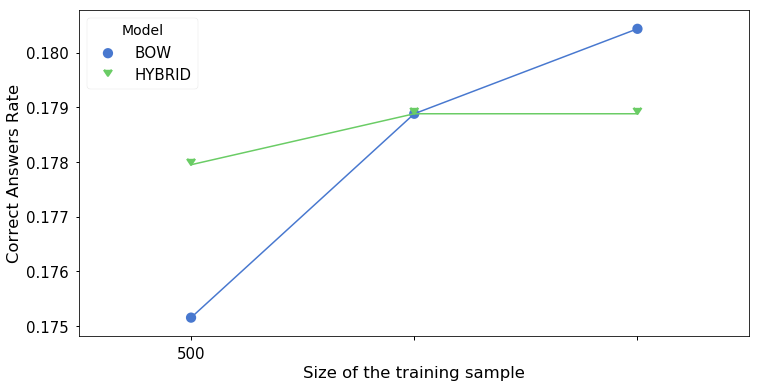

In [60]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

names = labels
df = pd.DataFrame(results)

aux = df[df.Model.map(lambda x: x in names)]

sorterIndex = dict(zip(names,range(len(names))))
aux['models_sort'] = aux['Model'].map(sorterIndex)
aux.sort_values(['Model'], \
        ascending = [1], inplace = True)
aux.drop('models_sort', 1, inplace = True)


col_list = ["black", "black", "black", "black", "black"]
col_list_palette = sns.xkcd_palette(col_list)
#sns.set_palette(col_list_palette)
sns.set_palette(sns.color_palette("muted", 5))


#df = df.drop('accuracy', 1).drop('precision', 1).drop('recall', 1).drop('train_size', 1)

plt.figure(figsize=(12, 6))

fig = sns.pointplot(x='train_size', y='rate', hue='Model', 
                    data=df[df.Model.map(lambda x: x in names)],
                    markers=['o',7,'p','s','x'],lineheight=1)

for ind, label in enumerate(fig.get_xticklabels()):
    if ind == 0 or ind == 5 or ind == 10 or ind == 15 or ind == 20:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(fig.lines,linewidth=1.5)
sns.set_context("notebook", font_scale=1.5)
fig.set(xlabel="Size of the training sample")
fig.set(ylabel="Correct Answers Rate")

[Text(0,0.5,'F-Score')]

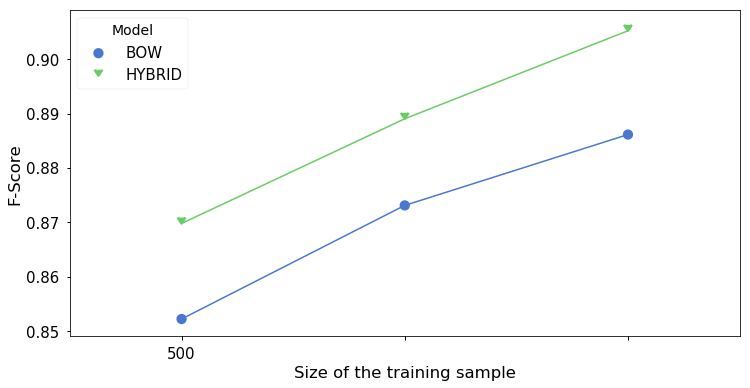

In [61]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

names = labels
df = pd.DataFrame(qc_results)

aux = df[df.Model.map(lambda x: x in names)]

sorterIndex = dict(zip(names,range(len(names))))
aux['models_sort'] = aux['Model'].map(sorterIndex)
aux.sort_values(['Model'], \
        ascending = [1], inplace = True)
aux.drop('models_sort', 1, inplace = True)


col_list = ["black", "black", "black", "black", "black"]
col_list_palette = sns.xkcd_palette(col_list)
#sns.set_palette(col_list_palette)
sns.set_palette(sns.color_palette("muted", 5))


#df = df.drop('accuracy', 1).drop('precision', 1).drop('recall', 1).drop('train_size', 1)

plt.figure(figsize=(12, 6))

fig = sns.pointplot(x='train_size', y='f1', hue='Model', 
                    data=df[df.Model.map(lambda x: x in names)],
                    markers=['o',7,'p','s','x'],lineheight=1)

for ind, label in enumerate(fig.get_xticklabels()):
    if ind == 0 or ind == 5 or ind == 10 or ind == 15 or ind == 20:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(fig.lines,linewidth=1.5)
sns.set_context("notebook", font_scale=1.5)
fig.set(xlabel="Size of the training sample")
fig.set(ylabel="F-Score")

In [ ]:
import scipy

a = []
b = []

for t in results:
    if t['Model'] == labels[3]:
        a.append(t['rate'])
    if t['Model'] == labels[0]:
        b.append(t['rate'])

scipy.stats.ttest_ind(a, b)

### Util

In [ ]:
import importlib
importlib.reload(QA)
#raise IpyExit

In [ ]:
labels = ["BoW_WF", 
          "BoW_TFIDF", 
          "W2V",
          "HYBRID_WF",
          "HYBRID_TFIDF"]